In [4]:
import os
import yaml
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from astropy.io import fits


# read configuration file
with open('config.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [5]:
bands = ['g', 'r', 'i', 'z', 'y']

In [6]:
sample_idx = 0

def sort_by_band(files, bands):
    band_map = {b: i for i, b in enumerate(bands)}
    def get_band(f):
        for b in bands:
            if f"_{b}.fits" in f:
                return band_map[b]
        return -1
    return sorted(files, key=get_band)

hsc_lens_fits_files = sort_by_band(
    glob(os.path.join(config['data_dir'], 'hsc_lenses', f'*_{str(sample_idx).zfill(8)}_*.fits')), bands)
hsc_nonlens_fits_files = sort_by_band(
    glob(os.path.join(config['data_dir'], 'hsc_nonlenses', f'*_{str(sample_idx).zfill(8)}_*.fits')), bands)
slsim_lens_fits_files = sort_by_band(
    glob(os.path.join(config['data_dir'], 'slsim_lenses', f'*_{str(sample_idx).zfill(8)}_*.fits')), bands)
slsim_nonlens_fits_files = sort_by_band(
    glob(os.path.join(config['data_dir'], 'slsim_nonlenses', f'*_{str(sample_idx).zfill(8)}_*.fits')), bands)

assert len(hsc_lens_fits_files) == len(hsc_nonlens_fits_files) == len(slsim_lens_fits_files) == len(slsim_nonlens_fits_files) == 5

In [7]:
pprint(hsc_lens_fits_files)

['/nfsdata1/bwedig/lsst-strong-lens-data-challenge/hsc_lenses/D2_L_00000000_g.fits',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/hsc_lenses/D2_L_00000000_r.fits',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/hsc_lenses/D2_L_00000000_i.fits',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/hsc_lenses/D2_L_00000000_z.fits',
 '/nfsdata1/bwedig/lsst-strong-lens-data-challenge/hsc_lenses/D2_L_00000000_y.fits']


In [8]:
def get_image_data(f):
    """
    Returns a tuple (Lens ID, image)
    """
    fits_data = fits.getdata(f, ext=1)
    return fits_data[0][0], fits_data[0][1]

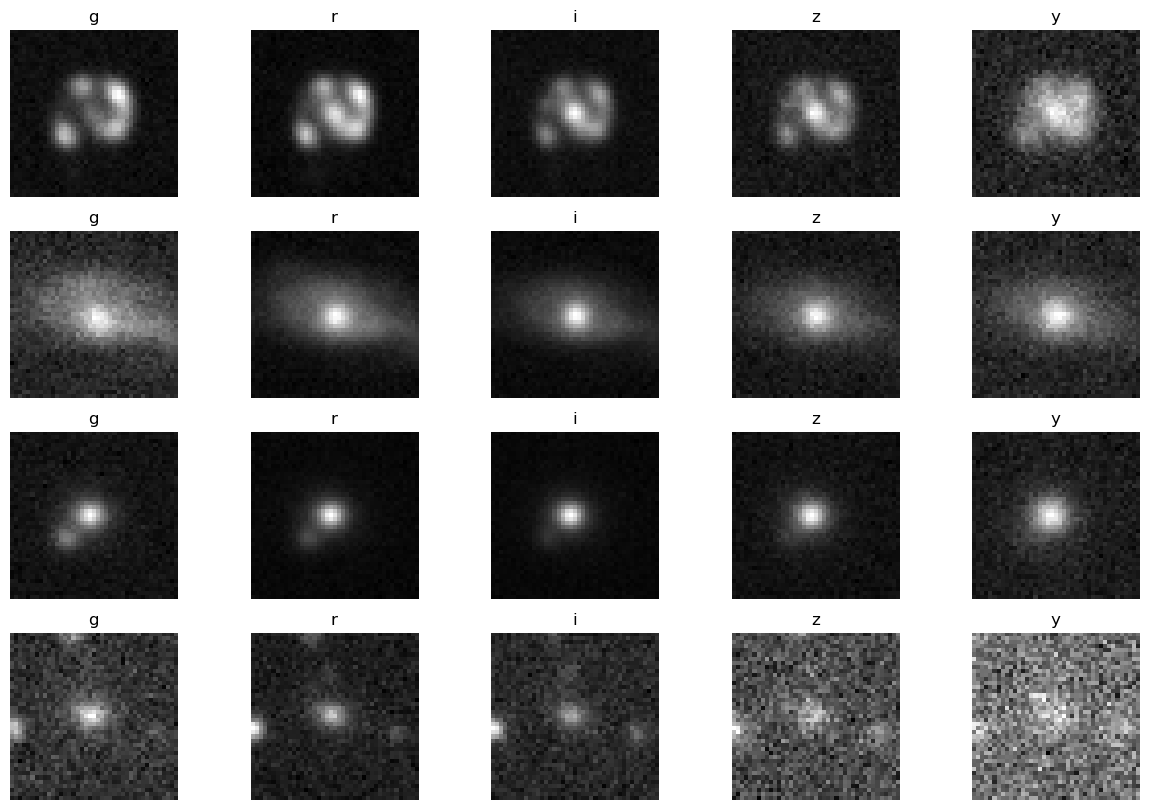

In [9]:
f, ax = plt.subplots(4, 5, figsize=(15, 10))

files = hsc_lens_fits_files + hsc_nonlens_fits_files + slsim_lens_fits_files + slsim_nonlens_fits_files

for i, a in enumerate(ax.flatten()):
    lens_id, image = get_image_data(files[i])
    a.imshow(image, cmap='gray')
    a.set_title(f'{bands[i % 5]}')
    a.axis('off')

plt.show()

In [10]:
from scipy.optimize import minimize

def objective_function(gamma, image, desired_median):
    gamma_corrected_image = np.power(image, gamma)
    median_value = np.median(gamma_corrected_image)
    return (median_value - desired_median)**2

def find_gamma(image, desired_median=0.2, initial_gamma=0.7):
    result = minimize(objective_function, initial_gamma, args=(image, desired_median), method='Nelder-Mead')
    return result.x[0]

Gamma 0.652626953125 achieves median 0.19999464855330434


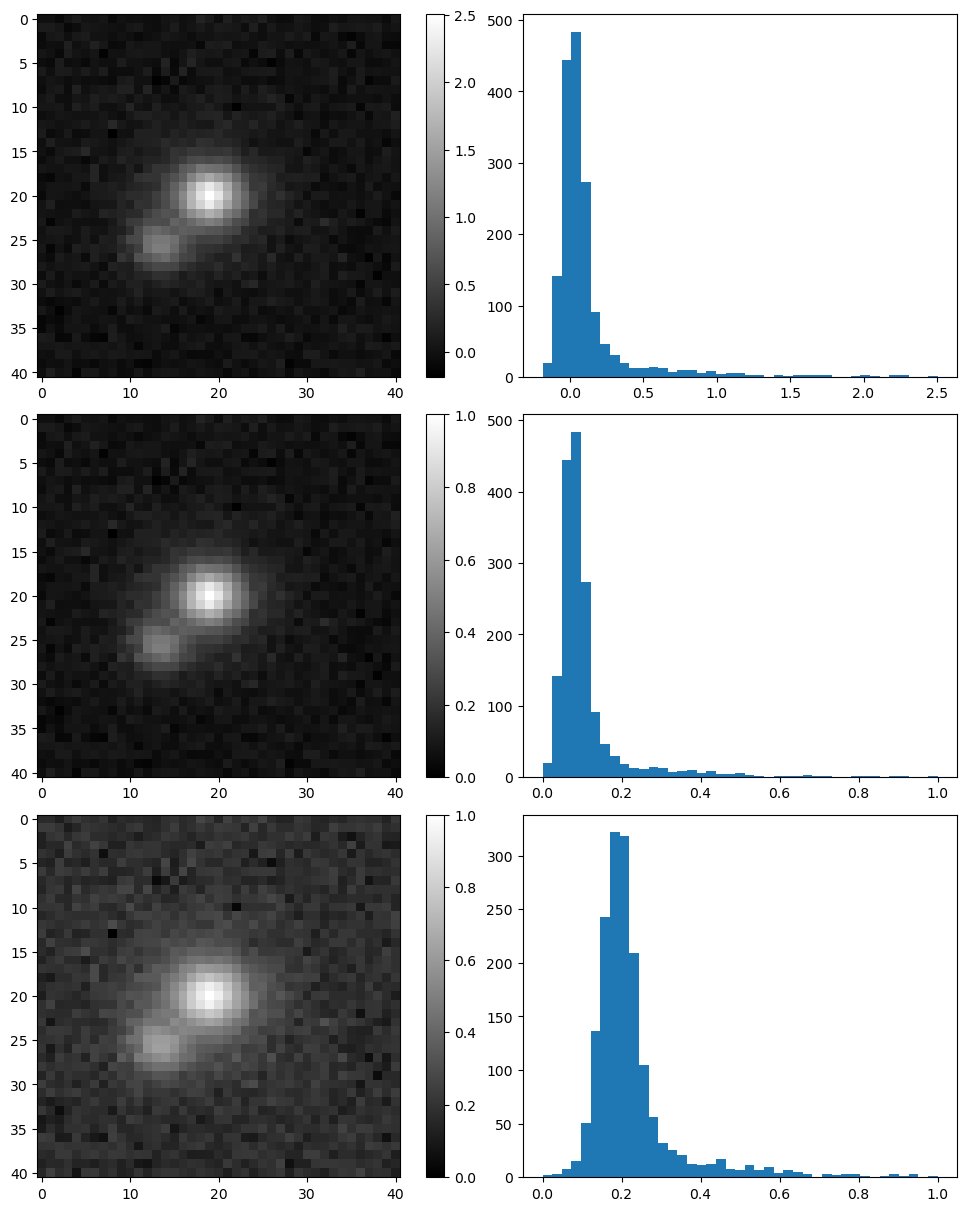

In [11]:
_, slsim_sample_g = get_image_data(slsim_lens_fits_files[0])

f, ax = plt.subplots(3, 2, constrained_layout=True, figsize=(10, 12))
im = ax[0][0].imshow(slsim_sample_g, cmap='gray')
f.colorbar(im, ax=ax[0][0], orientation='vertical')
ax[0][1].hist(slsim_sample_g.ravel(), bins=int(np.sqrt(41 * 41)))

slsim_sample_g_norm = (slsim_sample_g - np.min(slsim_sample_g)) / (np.max(slsim_sample_g) - np.min(slsim_sample_g))

im = ax[1][0].imshow(slsim_sample_g_norm, cmap='gray')
f.colorbar(im, ax=ax[1][0], orientation='vertical')
ax[1][1].hist(slsim_sample_g_norm.ravel(), bins=int(np.sqrt(41 * 41)))

gamma = find_gamma(slsim_sample_g_norm, desired_median=0.2)
print(f'Gamma {gamma} achieves median {np.median(np.power(slsim_sample_g_norm, gamma))}')
slsim_sample_g_gamma = np.power(slsim_sample_g_norm, gamma)

im = ax[2][0].imshow(slsim_sample_g_gamma, cmap='gray')
f.colorbar(im, ax=ax[2][0], orientation='vertical')
ax[2][1].hist(slsim_sample_g_gamma.ravel(), bins=int(np.sqrt(41 * 41)))

plt.show()